# 1. Описание проекта

<p align="center">
  <img src="https://x-lines.ru/letters/i/cyrillictechno/3504/01525f/32/0/4nkpbpqozuem7wfu4gypbcgtouemtwcx.jpg"/>
</p>

#### Проблема:
> Население - важнейший показатель "здоровья" как страны в-целом, так и отдельных населенных пунктов в-частности. В последние десятилетия демографические процессы, происходящие в России, имеют ярко выраженный негативный характер. Однако, данная тенденция неравномерна: где-то численность резко возрастает, где-то резко падает, а где-то "топчется на месте".
>
> Всё это напрямую влияет на экономические процессы и, соответственно, на качество жизни людей.

#### Цели:
> Прогнозирование динамики численности населения по населённому пункту поможет органам государственной и муниципальной власти корректировать свои программы в этом направлении для достижения наилучших социальных результатов, а бизнесу понять численность орентировочного локального рынка потребителей и рабочей силы на годы вперёд.

#### Техническая задача:
> Собрать официальную статистику по демографическим, социальным и экономическим показателям, провести анализ полученных данных. На основании проведённого анализа создать модель машинного обучения, предсказывающего численность населения в конкретном населённом пункте. Модель задеплоить в тг-бот, где пользователь вводит название населённого пункта, далее нужный ему год, после этого показывается результат предсказания.

# 2. Загрузка данных и библиотек

In [476]:
# Загружаем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_percentage_error
import pickle

import warnings
warnings.filterwarnings('ignore')

import plotly.io as pio
pio.renderers.default='colab'

> Основу данных, конечно же, составит наименование городов, регионов, в которых они расположены, а также численность населения по годам.

In [477]:
# Загружаем предварительно собранный датасет о численности населения городов России - это основной файл

cities_population = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/population.csv', index_col=0)
cities_population

,Город,Регион,Год,Численность
0,Абаза,Республика Хакасия,1959,11600
1,Абаза,Республика Хакасия,1970,15200
2,Абаза,Республика Хакасия,1979,15800
3,Абаза,Республика Хакасия,1989,17600
4,Абаза,Республика Хакасия,1992,18000
...,...,...,...,...
29885,Яхрома,Московская область,2017,14200
29886,Яхрома,Московская область,2018,14300
29887,Яхрома,Московская область,2019,14300
29888,Яхрома,Московская область,2020,14100


# 3. Анализ и подготовка данных

In [478]:
# Итак, посмотрим на информацию по датасету, который удалось собрать

cities_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29890 entries, 0 to 29889
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Город        29890 non-null  object
 1   Регион       29890 non-null  object
 2   Год          29890 non-null  int64 
 3   Численность  29890 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


> Сразу же обращаем внимание на то, что пропусков в данных нет, а общая размерность составляет 29890 на 4.
>
> Так как признаков в этом датасете всего 4, посмотрим детально на каждый из них, с точки зрения выборочной статистики.

In [479]:
print(f"Количество городов: {cities_population['Город'].nunique()}")
print(f"Количество регионов: {cities_population['Регион'].nunique()}")
print(f"Минимальный год: {cities_population['Год'].min()}, максимальный: {cities_population['Год'].max()}")
print(f"Минимальная численность: {cities_population['Численность'].min()}, максимальная: {cities_population['Численность'].max()}")

Количество городов: 1094
Количество регионов: 85
Минимальный год: 1765, максимальный: 2021
Минимальная численность: 10, максимальная: 12480500


In [480]:
# Посмотрим на динамику численности населения

population_dinamic_scatter = px.scatter(cities_population,
                                        x = 'Год',
                                        y = 'Численность',
                                        color_discrete_sequence = ['maroon'],
                                        title = 'Динамика численности населения')
population_dinamic_scatter.update_layout(title_x=0.5, showlegend=False)
population_dinamic_scatter.show();

> Как мы можем видеть по графику, все, кроме двух городов, в настоящее времся имеют численность населения до 2 млн. человек.
> 
> По логике, эти два "выбивающихся" города должны быть Москва и Санкт-Петербург.

In [481]:
# Убедимся в этом

cities_population[(cities_population['Численность'] > 2000000) & (cities_population['Год'] == 2019)]['Город'].tolist()

['Москва', 'Санкт-Петербург']


>**Итак, пора переходить к более фундаментальным вопросам, а именно к факторам, влияющим на демографические изменения.**
>
> Среди важнейших факторов/показателей можно выделить следующие:

*   Валовый региональный продукт (ВРП)
*   Доход на человека
*   Безработица
*   Смертность
*   Образование
*   Преступность
*   Строительство жилья
*   Индекс человеческого развития (ИЧР)

> Так как большинство данных по многим, особенно небольшим, городам попросту отсутствуют, за соответствующие показатели будем брать **данные по регионам**, где эти города расположены.
>
> Почти вегда показатели в городах напрямую коррелируют с данными по регионам, в-целом, где они расположены. 

**Если данные за какие-либо года в отдельных регионах отсутствуют, то эти пропущенные значения заменяются первыми имеющимися соседними показателями из соответствующего региона.**


---



> Начнём с ВРП - **валового регионального продукта**. Данный показатель напрямую отражает экономического состояние региона.

> Единица измерения: руб. на душу населения.

In [482]:
# Загружаем подготовленный датасет

grp = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/grp.csv', index_col=0)
grp.head()

,Регион,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Белгородская область,9575.6,10792.2,12242.8,21398.0,27969.5,33126.7,41327.4,50271.4,75629.4,...,331010.0,354570.6,368874.8,400820.8,447619.7,501467.8,539720.5,588641.5,617426.5,646569.0
1,Брянская область,7275.3,7175.7,7659.1,11752.4,17413.5,21511.9,27020.0,31953.4,37719.1,...,137187.1,164726.6,175865.0,196096.7,221080.0,258752.7,280630.1,304547.1,332442.8,347204.5
2,Владимирская область,7620.7,8431.3,9350.2,15457.1,21073.3,27170.0,32923.6,40809.4,49353.4,...,181842.6,200456.4,216320.8,232757.6,262945.5,309713.7,325043.1,349856.4,394560.3,410443.6
3,Воронежская область,7651.9,8686.6,9082.1,14808.3,20365.1,24905.4,34789.6,42237.5,49530.0,...,203575.5,241947.4,262578.3,308004.7,345566.8,354657.9,374125.7,408140.7,431037.0,459629.5
4,Ивановская область,6725.4,6379.3,6804.5,9765.2,14240.0,18947.2,23396.9,29192.4,35732.7,...,121945.5,129448.3,151263.6,146032.6,174687.5,200504.4,208522.0,230325.5,249591.6,273821.5


In [483]:
# Приведём столбцы с годами в строки и создадим отдельный столбец в ВРП

grp = pd.melt(grp, id_vars=['Регион'], var_name='Год', value_name='ВРП').sort_values(['Регион', 'Год']).reset_index(drop=True)
grp['Год'] = grp['Год'].astype('int')
grp.head()

,Регион,Год,ВРП
0,Алтайский край,1996,7605.8
1,Алтайский край,1997,7431.0
2,Алтайский край,1998,8012.4
3,Алтайский край,1999,12204.8
4,Алтайский край,2000,17660.5


In [484]:
# Проверим соответствует ли количество регионов в таблице с численность таблице с ВПР

cities_population['Регион'].nunique() == grp['Регион'].nunique()

True

In [485]:
# Посмотрим на динамику ВРП на душу населения, в-целом

grp_grouped = grp.groupby(['Год'], as_index=False)['ВРП'].sum()
grp_dinamic_line = px.line(grp_grouped,
                           x = 'Год',
                           y = 'ВРП',
                           color_discrete_sequence = ['darkgreen'],
                           title = 'Динамика ВРП')
grp_dinamic_line.update_layout(title_x=0.5, showlegend=False)
grp_dinamic_line.show();

> Как мы можем видеть, динамика ВРП на душу населения по стране, в-целом, положительна почти на всех временных участках.
>
> Данный показатель может свидетельствовать о том, что уровень жизни должен улучшаться вместе с экономическим состоянием региона.


---



> Переходим к одному из самых важных показателей в жизни человека - **доходам**.

> Единица измерения: средние реальные доходы на человека в рублях.

In [486]:
# Загружаем подготовленный датасет

incomes = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/incomes.csv', index_col=0)
incomes.head()

,Регион,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Белгородская область,392.5,593.3,657.6,717.5,1187.1,1554.5,2121.4,2762.3,3357.4,...,21659.5,23247,24750,28043,29799,30342,30778,32398,32884,35612
1,Брянская область,342.8,528.8,601.4,592.7,945.7,1312.1,1818.3,2452.4,3134.6,...,17469.4,18707,20595,23428,24006,25107,26658,28422,28636,31608
2,Владимирская область,317.7,473.2,577.3,593.5,994.5,1279.6,1665.9,2158.0,2842.0,...,16228.8,18058,19530,22712,22365,23554,23560,25391,25955,28489
3,Воронежская область,345.0,468.0,676.2,787.1,1186.0,1486.5,2039.7,2597.4,3391.2,...,18947.7,21683,24973,29366,29284,29498,30289,32022,32102,35100
4,Ивановская область,309.9,460.5,555.2,522.2,756.7,1037.6,1297.8,1778.4,2293.1,...,16014.7,17754,19832,22297,23676,24860,24503,25794,26284,28680


In [487]:
# Приведём столбцы с годами в строки и создадим отдельный столбец с доходами

incomes = pd.melt(incomes, id_vars=['Регион'], var_name='Год', value_name='Доход').sort_values(['Регион', 'Год']).reset_index(drop=True)
incomes['Год'] = incomes['Год'].astype('int')
incomes.head()

,Регион,Год,Доход
0,Алтайский край,1995,348.8
1,Алтайский край,1996,436.5
2,Алтайский край,1997,505.9
3,Алтайский край,1998,533.0
4,Алтайский край,1999,907.4


In [488]:
# Посмотрим на топ-10 регионов по среднему доходу за последние 10 лет

incomes_top = incomes[incomes['Год'] > 2010].groupby(['Регион'], as_index=False)['Доход'].mean().sort_values('Доход', ascending=False)[:10]
incomes_top['Доход'] = incomes_top['Доход'].apply(lambda x: int(x))


incomes_top_bar = px.bar(incomes_top,
                         height = 800,
                         x = 'Регион',
                         y = 'Доход',
                         color_discrete_sequence = ['dodgerblue'],
                         title = 'ТОП-10 регионов по среднему доходу населения за последние 10 лет')
incomes_top_bar.update_layout(title_x=0.5, showlegend=False)
incomes_top_bar.show();

> Ожидаемо, лидерами по доходам стали нефтегазовые регионы, отдалённые регионы и две столицы.
> 
> В столицы и их области люди переезжают из-за более высокого качества жизни и соответствующих возможностей и зарплат. Казалось бы, что и в регионы Сибири и Дальнего Востока люди переезжают из высоких зарплат, но это не всегда так. Давайте посмотрим на графике динамику за последние 20 лет.

In [489]:
population_in_top_incomes_regions = cities_population[(cities_population['Регион'].isin(incomes_top['Регион'])) & (cities_population['Год'] > 1999)].drop('Город', axis=1).reset_index(drop=True)
population_in_top_incomes_regions_pivot = population_in_top_incomes_regions.pivot_table(index='Год', columns='Регион', values='Численность', aggfunc='sum')

population_in_top_incomes_regions_line = px.line(population_in_top_incomes_regions_pivot,
                                                 height = 800,
                                                 labels = {'value': 'Численность'},
                                                 title = 'Динамика численности населения в регионах с наивысшим доходом на человека')
population_in_top_incomes_regions_line.update_layout(title_x=0.5, showlegend=True)
population_in_top_incomes_regions_line.show();

> Как мы можем видеть, каких-либо резких изменений не происходит, даже несмотря на высокие зарплаты, а иногда численность даже уменьшается. Это означает, что не всегда высокие доходы привлекают людей.


---



> За следующий показатель, отражающим состояние дел в экономике и социальной сфере, берём **безработицу**.

> Единица измерения: процент (%) от числа трудоспособного населения.

In [490]:
# Загружаем подготовленный датасет

unemployment = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/unemployment.csv', index_col=0)
unemployment.head()

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Белгородская область,6.1,6.4,8.1,8.3,6.2,5.9,5.6,4.3,3.9,...,3.7,4.0,4.0,4.1,4.0,3.9,4.0,3.9,4.9,4.2
1,Брянская область,13.4,9.8,8.6,7.4,8.9,6.8,6.8,6.4,6.5,...,5.1,5.2,5.0,4.6,4.6,4.4,3.9,3.8,4.0,3.4
2,Владимирская область,12.0,10.2,10.4,10.2,9.1,9.0,10.8,6.7,5.7,...,4.4,3.8,4.3,5.6,5.6,4.8,4.7,4.0,5.6,3.9
3,Воронежская область,10.1,9.6,8.9,8.3,8.7,7.6,5.4,5.2,5.2,...,5.5,4.7,4.5,4.5,4.5,4.3,3.7,3.5,4.3,3.8
4,Ивановская область,10.4,5.9,6.9,6.5,4.7,6.9,4.2,4.3,5.2,...,6.3,5.2,4.3,5.6,5.6,4.7,4.2,3.8,5.4,4.5


> У части регионов статистика появилась с начала её общего ведения, поэтому пропущенные значения заменены значением из первого года, когда информация в регионе появилась.

In [491]:
# Приведём столбцы с годами в строки и создадим отдельный столбец с безработицей

unemployment = pd.melt(unemployment, id_vars=['Регион'], var_name='Год', value_name='Безработица').sort_values(['Регион', 'Год']).reset_index(drop=True)
unemployment['Год'] = unemployment['Год'].astype('int')
unemployment.head()

,Регион,Год,Безработица
0,Алтайский край,2000,11.7
1,Алтайский край,2001,10.0
2,Алтайский край,2002,8.3
3,Алтайский край,2003,12.3
4,Алтайский край,2004,9.1


In [492]:
# Посмотрим на топ-10 регионов по самой высокой средней безработице за последние 5 лет

unemployment_worst = unemployment[unemployment['Год'] > 2016].groupby(['Регион'], as_index=False)['Безработица'].mean().sort_values('Безработица', ascending=False)[:10]
unemployment_worst['Безработица'] = unemployment_worst['Безработица'].apply(lambda x: int(x))


unemployment_top_bar = px.bar(unemployment_worst,
                              height = 800,
                              x = 'Регион',
                              y = 'Безработица',
                              color_discrete_sequence = ['firebrick'],
                              title = 'Регионы с самой высокой безработицей за последние 5 лет')
unemployment_top_bar.update_layout(title_x=0.5, showlegend=False)
unemployment_top_bar.show();

In [493]:
# Посмотрим на топ-10 регионов по самой низкой средней безработице за последние 5 лет

unemployment_best = unemployment[unemployment['Год'] > 2016].groupby(['Регион'], as_index=False)['Безработица'].mean().sort_values('Безработица')[:10]
unemployment_best['Безработица'] = unemployment_best['Безработица'].apply(lambda x: int(x))


unemployment_top_bar = px.bar(unemployment_best,
                              height = 800,
                              x = 'Регион',
                              y = 'Безработица',
                              color_discrete_sequence = ['forestgreen'],
                              title = 'Регионы с самой низкой безработицей за последние 5 лет')
unemployment_top_bar.update_layout(title_x=0.5, showlegend=False)
unemployment_top_bar.show();

In [494]:
# Посмотрим на общую динамику безработицы в стране, берём среднее значение по всем регионам

unemployment_grouped = unemployment.groupby(['Год'], as_index=False)['Безработица'].mean()
unemployment_grouped_line = px.line(unemployment_grouped,
                               x = 'Год',
                               y = 'Безработица',
                               color_discrete_sequence = ['lightseagreen'],
                               title = 'Динамика безработицы в России')
unemployment_grouped_line.update_layout(title_x=0.5, showlegend=False)
unemployment_grouped_line.show();

> Итак, на основании трех построенных графиков мы имеем примерную картину об общем положении дел с точки зрения безработицы.

> Рассматривая общую динамику, мы видим, что безработица в стране снижается с иногда возникающими всплесками. Их можно объяснить различными геополитическими и экономическими воздействиями, например, экономический кризис 2008-2009 годов или пандемия COVID-19 в 2020 году. Оба этих всплекса мы также видим на графике.

> Что касается регионов: самыми депрессивными в плане безработицы стали южные национальные республики, а также ряд прибайкальских регионов. Указанные регионы являются дотационными, что подчёркивает слабую внутреннюю промышленность и, соответственно, высокую долю не занятых в труде людей.
>
> При этом, самыми лучшими регионами, ожидаемо, стали Москва и СПб, а также ряд нефтегазовых регионов и регионов центральной России. Большинство предприятий, как раз, сосредоточены в европейской части России, что обуславливает низкую безработицу, а нефтегазовые регионы имеют множество рабочих мест на соответствующих предприятиях, при этом, инвестиции в эти направления только увеличиваются, что поддержит низкий уровень безработицы или даже ещё его сократит.


---



> Далее перейдем к показателю **смертности** населения. Чем выше в регионе уровень преступности, безработицы, алкоголизма, наркомании, ДТП и, в-целом, хуже уровень жизни, то и смертность возрастает.

> Единица измерения: количество смертей на на 100 тыс. населения.

In [495]:
# Загружаем подготовленный датасет

mortality = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/mortality.csv', index_col=0)
mortality.head()

,Регион,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Белгородская область,475.2,478.0,494.5,465.9,451.6,424.7,422.5,415.8,472.6,507.6
1,Брянская область,681.6,652.0,693.3,634.4,606.6,582.2,577.9,567.3,626.5,692.2
2,Владимирская область,715.3,679.5,690.4,654.0,634.4,597.2,593.9,562.3,648.3,701.1
3,Воронежская область,573.8,576.3,597.7,561.5,537.2,481.3,474.5,474.5,526.4,605.6
4,Ивановская область,657.9,634.3,642.3,614.0,593.0,574.5,584.4,562.6,601.1,650.5


In [496]:
# Приведём столбцы с годами в строки и создадим отдельный столбец со смертностью

mortality = pd.melt(mortality, id_vars=['Регион'], var_name='Год', value_name='Смертность').sort_values(['Регион', 'Год']).reset_index(drop=True)
mortality['Год'] = mortality['Год'].astype('int')
mortality.head()

,Регион,Год,Смертность
0,Алтайский край,2012,637.2
1,Алтайский край,2013,623.1
2,Алтайский край,2014,611.8
3,Алтайский край,2015,597.5
4,Алтайский край,2016,583.8


In [497]:
# Посмотрим на общую динамику смертности в стране, берём среднее значение по всем регионам

mortality_grouped = mortality.groupby(['Год'], as_index=False)['Смертность'].mean()
mortality_grouped_line = px.line(mortality_grouped,
                                 x = 'Год',
                                 y = 'Смертность',
                                 color_discrete_sequence = ['black'],
                                 title = 'Динамика смертности в России')
mortality_grouped_line.update_layout(title_x=0.5, showlegend=False)
mortality_grouped_line.show('colab');

In [498]:
# Посмотрим на 5 худших и 5 лучших региона по данному показателю (берём среднее за все доступные года) в динамике

low_mortality = mortality.groupby(['Регион'], as_index=False)['Смертность'].mean().sort_values('Смертность')[:5]
high_mortality = mortality.groupby(['Регион'], as_index=False)['Смертность'].mean().sort_values('Смертность', ascending=False)[:5]

lowest_and_highest_mortality = mortality[(mortality['Регион'].isin(low_mortality['Регион'])) | (mortality['Регион'].isin(high_mortality['Регион']))].reset_index(drop=True)
lowest_and_highest_mortality_pivot = lowest_and_highest_mortality.pivot_table(index='Год', columns='Регион', values='Смертность', aggfunc='sum')

lowest_and_highest_mortality_line = px.line(lowest_and_highest_mortality_pivot,
                                            height = 600,
                                            labels = {'value': 'Смертность'},
                                            title = 'Динамика смертности населения в самых лучших и в самых худших регионах по данному показателю')
lowest_and_highest_mortality_line.update_layout(title_x=0.5, showlegend=True)
lowest_and_highest_mortality_line.show();

> Ожидаемо, в числе худших регионов по показателю смертности оказались дальневосточные и восточно-сибирские регионы. Как правило, именно эти регионы чаще всего фигурируют во всевозможных антирейтингах, в том числе, по уровню алгоколизма и преступности. Всё это лишний раз говорит о депрессивном состоянии данных субъектов, снижению уровня жизни населения и, соответственно, о демографической катастрофе. Несмотря на постепенно снижающуюся общую динамику смертности, она всё ещё высока, даже по сравнению с общероссийским уровнем. А если сравнить с лучшими регионами по данному показателю, то разница колоссальна (в несколько раз!).

> А этими лучшими субъектами РФ являются региона Кавказа. Можно предположить, что такая низкая смертность, даже по сравнению с общероссийским уровнем, связана с мягким климатом, чистой окружающей средой, низким уровнем преступности и алкоголизма. Последние показатели напрямую связаны с религией данных регионов - мусульманством.


> Дополнительно стоит отметить, что показатель смертности является хорошим маркером, отражающим как социальное, так и экономическое состояние региона. Например, чем лучше развито здравоохранение в регионе, чем больше в нём медицинский учреждений и врачей, чем больше людей занимаются спортом, а не употребляют алкоголь и наркотики, тем дольше продолжительность жизни и меньше риск смерти не только от возраста, но и по состоянию здоровья.
---



> Раз мы рассмотрели тему смертности и затронули в ней **преступность**, как один из факторов, то познакомимся с данным показателем поподробнее.

> Единица измерения: количество смертей на на 100 тыс. населения.
> Изначально данные были в формате фактического количества, далее был произведён перерасчёт к показателю на 100 тыс. населения.

In [499]:
# Загружаем подготовленный датасет

crimes = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/crimes.csv', index_col=0)
crimes.head()

,Регион,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Белгородская область,1085,1024,959,961,921,1017,883,821,848,915,924,906
1,Брянская область,1923,1595,1535,1562,1401,1419,1296,1184,1171,1177,1244,1164
2,Владимирская область,1846,1715,1565,1341,1353,1536,1377,1314,1242,1208,1250,1169
3,Воронежская область,1176,1157,1185,1303,1445,1683,1472,1395,1255,1319,1264,1265
4,Ивановская область,1841,1682,1559,1418,1454,1480,1408,1558,1372,1358,1344,1179


In [500]:
# Приведём столбцы с годами в строки и создадим отдельный столбец с преступностью

crimes = pd.melt(crimes, id_vars=['Регион'], var_name='Год', value_name='Преступность').sort_values(['Регион', 'Год']).reset_index(drop=True)
crimes['Год'] = crimes['Год'].astype('int')
crimes.head()

,Регион,Год,Преступность
0,Алтайский край,2010,2030
1,Алтайский край,2011,1900
2,Алтайский край,2012,1780
3,Алтайский край,2013,1903
4,Алтайский край,2014,1864


In [501]:
# Так как мы проводим параллели со смертностью, то вспомним регионы с худшими показателями

high_mortality['Регион'].to_list()

['Чукотский автономный округ',
 'Республика Тыва',
 'Еврейская автономная область',
 'Магаданская область',
 'Кемеровская область']

In [502]:
# Посмотрим являются ли лидерами антирейтинга данные регионы по показателю преступности, выгрузим 10 худших регионов

high_crime = crimes.groupby(['Регион'], as_index=False)['Преступность'].mean().sort_values('Преступность', ascending=False)[:10]
high_crime

,Регион,Преступность
14,Забайкальский край,2628.083333
60,Республика Тыва,2514.666667
48,Республика Бурятия,2408.750000
1,Амурская область,2276.000000
27,Курганская область,2236.000000
22,Кемеровская область,2187.250000
13,Еврейская автономная область,2186.583333
46,Республика Алтай,2181.833333
66,Сахалинская область,2175.916667
43,Приморский край,2168.583333


> Как мы видим, 3 из 5 худших регионов по показателю смертности лидируют и по показателю преступности. А если расширить выборку худших регионов по преступности до 15, то там окажутся уже 4 из 5 регионов из списка смертности.

In [503]:
# Посмотрим на ту же самую информацию для лучших регионов
# Конечно же, сначала вспомним их список

low_mortality['Регион'].to_list()

['Республика Ингушетия',
 'Республика Дагестан',
 'Чеченская Республика',
 'Кабардино-Балкарская Республика',
 'Карачаево-Черкесская Республика']

In [504]:
# Выгрузим 10 лучших регионов по показателю преступности

low_crime = crimes.groupby(['Регион'], as_index=False)['Преступность'].mean().sort_values('Преступность')[:10]
low_crime

,Регион,Преступность
80,Чеченская Республика,261.250000
50,Республика Ингушетия,374.916667
49,Республика Дагестан,462.000000
21,Карачаево-Черкесская Республика,862.583333
63,Рязанская область,868.416667
73,Тульская область,901.000000
17,Кабардино-Балкарская Республика,916.666667
4,Белгородская область,938.666667
45,Республика Адыгея,962.500000
41,Пензенская область,1010.916667


> Здесь картина получилась ещё нагляднее - все регионы из списка с самой низкой смертностью находятся и в списке с самой низкой преступностью.

> Таким образом, делаем вывод, что смертность и преступность сильно коррелируют между собой.

In [505]:
# Для общего понимания построим график динамики преступности в России

crimes_grouped = crimes.groupby(['Год'], as_index=False)['Преступность'].mean()
crimes_grouped_line = px.line(crimes_grouped,
                              x = 'Год',
                              y = 'Преступность',
                              color_discrete_sequence = ['red'],
                              title = 'Динамика преступности в России')
crimes_grouped_line.update_layout(title_x=0.5, showlegend=False)
crimes_grouped_line.show();

> Если не брать во внимание один всплеск в 2015 году, то общая динамика уровню преступности положительна. По сравнению с 2010 годом, средняя преступность снизилась в 1.5 раза, что не может не сказываться на улучшении качества жизни людей.


---



> В качестве следующего рассматриваемого показателя берём **образование**. 

> Единица измерения: фактическое количество выпускников ВУЗов по регионам.

In [506]:
# Загружаем подготовленный датасет

education = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/education.csv')
education.head()

,Регион,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Белгородская область,8369,10014,10822,12017,13358,13490,12500,13031,12706,10759,12748,11103,9908,9700,9493
1,Брянская область,6856,8222,8338,8353,8649,9239,8648,8637,8871,8399,8884,7150,5931,5386,5481
2,Владимирская область,6389,8426,9146,9457,9620,9832,9506,9350,8820,7436,7142,7206,6002,6467,6429
3,Воронежская область,19457,19209,19447,20708,21330,22211,22777,22047,19333,18919,23114,18374,18233,18805,18323
4,Ивановская область,9767,10741,11078,10965,11230,11004,10030,9671,8381,7490,8388,7575,6128,5458,5077


In [507]:
# Приведём столбцы с годами в строки и создадим отдельный столбец с количеством выпусников ВУЗов

education = pd.melt(education, id_vars=['Регион'], var_name='Год', value_name='Образование').sort_values(['Регион', 'Год']).reset_index(drop=True)
education['Год'] = education['Год'].astype('int')
education.head()

,Регион,Год,Образование
0,Алтайский край,2005,12552
1,Алтайский край,2006,14897
2,Алтайский край,2007,14091
3,Алтайский край,2008,14273
4,Алтайский край,2009,14798


In [508]:
# Посмотрим на регионы, где выпускается больше и меньше всего людей с высшим образованием

low_education = education.groupby(['Регион'], as_index=False)['Образование'].mean().sort_values('Образование')[:5]
high_education = education.groupby(['Регион'], as_index=False)['Образование'].mean().sort_values('Образование', ascending=False)[:5]

lowest_and_highest_education = education[(education['Регион'].isin(low_education['Регион'])) | 
                                         (education['Регион'].isin(high_education['Регион']))].reset_index(drop=True)
lowest_and_highest_education_pivot = lowest_and_highest_education.pivot_table(index='Год', columns='Регион', values='Образование', aggfunc='sum')

lowest_and_highest_education_line = px.line(lowest_and_highest_education_pivot,
                                            height = 600,
                                            labels = {'value': 'Количество выпускников'},
                                            title = 'Динамика количества выпускников в самых лучших и в самых худших регионах по данному показателю')
lowest_and_highest_education_line.update_layout(title_x=0.5, showlegend=True)
lowest_and_highest_education_line.show();

> Ожидаемо, с большим отрывом в количестве выпускников лидируют Москва и СПб. Далее идут регионы из европейской части России или иных крупных городов. Список замыкают всё те же регионы из рассматриваемых антирейтингов.

> Количество выпускников напрямую свидетельствует о развитии образования в регионе, количестве учебных заведений и имеющего научного потенциала.

> Если в регионе почти не выпускаются люди с высшим образованием, то и общее развитие региона будет только ухудшаться, так как молодое поколение будет "оседать" там, где видит перспективы. Это напрямую скажется на демографической ситуации.


---



> Последним рассматриваемым показателем является **строительство жилья**.

> Единица измерения: $млн.м^2$. Значениями является объём введенного в эксплуатацию жилья за год по регионам.

In [509]:
# Загружаем подготовленный датасет

housing = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/housing.csv', index_col=0)
housing.head()

,Регион,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Белгородская область,0.7175,0.5040,0.5378,0.5414,0.5992,0.8177,0.8161,0.7588,0.7669,...,1.1482,1.21515,1.2946,1.4692,1.5549,1.3501,1.3005,1.2155,1.2604,1.1486
1,Брянская область,0.6331,0.5231,0.5725,0.4096,0.4010,0.3622,0.2527,0.2535,0.2633,...,0.4214,0.45302,0.5268,0.5507,0.6443,0.6651,0.5583,0.4031,0.4071,0.4267
2,Владимирская область,0.6289,0.4561,0.4511,0.5188,0.4401,0.3521,0.2953,0.2806,0.2858,...,0.4376,0.50779,0.5189,0.6060,0.6467,0.6557,0.6954,0.6528,0.7454,0.7262
3,Воронежская область,0.9397,0.7454,0.6763,0.6539,0.5526,0.6971,0.6211,0.6211,0.5403,...,0.9962,1.11037,1.3487,1.5729,1.6269,1.6790,1.6873,1.6911,1.8789,1.7258
4,Ивановская область,0.4988,0.3732,0.2315,0.2787,0.2857,0.2074,0.1536,0.1737,0.1273,...,0.2166,0.22186,0.2320,0.2526,0.2602,0.1768,0.3398,0.3691,0.3306,0.3332


In [510]:
# Приведём столбцы с годами в строки и создадим отдельный столбец с объемом построенного жилья

housing = pd.melt(housing, id_vars=['Регион'], var_name='Год', value_name='Ввод_жилья').sort_values(['Регион', 'Год']).reset_index(drop=True)
housing['Год'] = housing['Год'].astype('int')
housing.head()

,Регион,Год,Ввод_жилья
0,Алтайский край,1990,1.2521
1,Алтайский край,1991,0.9757
2,Алтайский край,1992,0.8576
3,Алтайский край,1993,0.7700
4,Алтайский край,1994,0.5553


In [511]:
# Традиционно, построим график общей динамики ввода жилья в России

housing_grouped = housing.groupby(['Год'], as_index=False)['Ввод_жилья'].mean()
housing_grouped_line = px.line(housing_grouped,
                               x = 'Год',
                               y = 'Ввод_жилья',
                               color_discrete_sequence = ['seagreen'],
                               labels = {'Ввод_жилья': 'Объём построенного жилья (млн.кв.м)'},
                               title = 'Динамика ввода жилья в России')
housing_grouped_line.update_layout(title_x=0.5, showlegend=False)
housing_grouped_line.show();

> На основании построенного графика мы видим, что после развала СССР объем вводимого жилья сократился в 2 раза. Начиная с 2000 года начинается резкий подъем жилижного строительства с небольшими проседаниями в отдельные года. Однако, общая положительная динамика говорит о позитивном экономическо развитии и об улучшении уровня жизни населения страны.

In [512]:
# Для наглядности разницы между регионами выведем по 5 регионов 
# с самым большим и с самым маленьким суммарным вводом жилья за последние 5 лет 

low_housing = housing[housing['Год'] > 2014].groupby(['Регион'], as_index=False)['Ввод_жилья'].sum().sort_values('Ввод_жилья')[:5]
high_housing = housing[housing['Год'] > 2014].groupby(['Регион'], as_index=False)['Ввод_жилья'].sum().sort_values('Ввод_жилья', ascending=False)[:5]

lowest_and_highest_housing = low_housing.merge(high_housing, how='outer').sort_values('Ввод_жилья', ascending=False)

lowest_and_highest_housing_bar = px.bar(lowest_and_highest_housing,
                                        x = 'Ввод_жилья',
                                        y = 'Регион',
                                        height = 600,
                                        color = 'Регион',
                                        labels = {'Ввод_жилья': 'Объём построенного жилья (млн.кв.м)'},
                                        title = 'Регионы с самым большим и маленьким вводом жилья за последние 5 лет')
lowest_and_highest_housing_bar.update_layout(title_x=0.5, showlegend=False)
lowest_and_highest_housing_bar.show();


> Тут снова всё ожидаемо: жилья значительно больше строится в европейской части России, причём в самым привлекательных регионах за последнее десятилетие, как за счёт экономического развития (Москва и СПБ + области), так и за счёт климата (Краснодарский край). Вводимые объемы жилья лишний раз подчёркивают положительную демографическую динамику в данных регионах.

> Напротив, лидерами антирейтинга стали те же регионы Севера и Дальнего Востока. При отсутствии положительной экономической и демографической динамики о вводе большого количества нового жилья речи не идёт.


---



> Завершающим показателем, обобщающим часть данных о жизни человека, является **индекс человеческого развития** (ИЧР). Данный показатель характеризует развитие человека, качество и уровень его жизни.

> Единица измерения: значение от 0 до 1, где 1 - самое высокое значение индекса.

In [513]:
# Загружаем подготовленный датасет

human_index = pd.read_csv('https://raw.githubusercontent.com/aeabramov/population_prediction/main/data/human_index.csv', index_col=0)
human_index.head()

,Регион,1999,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Алтайский край,0.730,0.729,0.731,0.729,0.733,0.735,0.738,0.756,0.769,...,0.796,0.805,0.805,0.822,0.831,0.834,0.834,0.824,0.838,0.840
1,Амурская область,0.714,0.711,0.725,0.730,0.728,0.726,0.731,0.744,0.759,...,0.789,0.803,0.818,0.817,0.820,0.828,0.831,0.840,0.840,0.844
2,Архангельская область,0.732,0.739,0.747,0.749,0.752,0.768,0.774,0.789,0.805,...,0.828,0.836,0.848,0.862,0.869,0.873,0.853,0.857,0.890,0.871
3,Астраханская область,0.741,0.748,0.743,0.747,0.753,0.758,0.760,0.770,0.779,...,0.808,0.812,0.824,0.843,0.863,0.864,0.865,0.869,0.886,0.900
4,Белгородская область,0.762,0.772,0.770,0.768,0.776,0.788,0.802,0.812,0.826,...,0.852,0.866,0.876,0.885,0.887,0.891,0.890,0.896,0.906,0.908


In [514]:
# Приведём столбцы с годами в строки и создадим отдельный столбец с ИЧР

human_index = pd.melt(human_index, id_vars=['Регион'], var_name='Год', value_name='ИЧР').sort_values(['Регион', 'Год']).reset_index(drop=True)
human_index['Год'] = human_index['Год'].astype('int')
human_index.head()

,Регион,Год,ИЧР
0,Алтайский край,1999,0.730
1,Алтайский край,2000,0.729
2,Алтайский край,2001,0.731
3,Алтайский край,2002,0.729
4,Алтайский край,2003,0.733


In [515]:
# Посмотрим на общее изменение ИЧР

human_index_grouped = human_index.groupby(['Год'], as_index=False)['ИЧР'].mean()
human_index_line = px.line(human_index_grouped,
                           x = 'Год',
                           y = 'ИЧР',
                           color_discrete_sequence = ['deeppink'],
                           title = 'Динамика Индекса человеческого развития')
human_index_line.update_layout(title_x=0.5, showlegend=False)
human_index_line.show();

> Как мы можем видеть, динамика ИЧР положительна на всех временных участках с момента начала ведения статистических наблюдений. Это свидетельствует о позитивном развитии многих направлений, затрагиващих жизнь человека, по стране, в-целом, но, конечно же, стоит понимать, что есть регионы, где совсем другая тенденция и более детально мы с ними уже познакомились ранее.

---



**Итак, мы рассмотрели основные факторы и показатели, влияющие на демографию регионов и находящихся в них городов.**

> На основании построенных графиков и сделанных из них выводов можно резюмировать: демографические изменения прямо коррелируют с экономическим и социальным состоянием региона. Люди уезжают из городов с низкими зарплатами, высокой преступностью, плохим здравоохранением, суровым климатом и отсутствием дальнейших для себя перспектив, в-целом.

> Человек всегда стремится к лучшей для себя жизни, и если какой-либо город предоставляет ему такую возможность, то он в нём остаётся. И, конечно же, если город привлекает людей, то растёт уровень жизни в нём и, соответственно, улучшается демографическое состояние как за счёт миграции из других мест, так и за счёт рождения детей у всё увеличивающегося населения.


# 4. Моделирование

> Итак, было собранно множество данных, по ним проведён анализ и сделаны выводы. 

> Теперь пора все данные объединить. Не имеет никакого смысла рассматривать данные из далёкого прошлого, так как экономические и социальные показатели могут изменяться довольно быстро, а где-то информация по ним попросту отсутствует.

> Поэтому за точку отсчёта берём **2000 год**.

In [516]:
population = cities_population.merge(grp, on=['Регион', 'Год'], how='left') # объединяем с данными по ВРП
population = population.merge(incomes, on=['Регион', 'Год'], how='left') # объединяем с данными по доходам
population = population.merge(unemployment, on=['Регион', 'Год'], how='left') # объединяем с данными по безработице
population = population.merge(mortality, on=['Регион', 'Год'], how='left') # объединяем с данными по смертности
population = population.merge(crimes, on=['Регион', 'Год'], how='left') # объединяем с данными по преступности
population = population.merge(education, on=['Регион', 'Год'], how='left') # объединяем с данными по количеству выпускников ВУЗов
population = population.merge(housing, on=['Регион', 'Год'], how='left') # объединяем с данными по объёмам построенного жилья
population = population.merge(human_index, on=['Регион', 'Год'], how='left') # объединяем с данными по ИЧР

In [517]:
# Если объединие произошло правильно, то количество строк должно быть равно количеству строк из таблицы cities_population
# Проверим это

population.shape[0] == cities_population.shape[0]

True

In [518]:
# Как и условились, отсекаем данные до 2000 года
# Так как за 2021 год статистическая информация появилась ещё не полностью или отсутствует вовсе, этот год также уберём

population = population[(population['Год'] > 1999) & (population['Год'] != 2021)].reset_index(drop=True)
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17530 entries, 0 to 17529
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Город         17530 non-null  object 
 1   Регион        17530 non-null  object 
 2   Год           17530 non-null  int64  
 3   Численность   17530 non-null  int64  
 4   ВРП           16935 non-null  float64
 5   Доход         16935 non-null  float64
 6   Безработица   16935 non-null  float64
 7   Смертность    8531 non-null   float64
 8   Преступность  10660 non-null  float64
 9   Образование   13053 non-null  float64
 10  Ввод_жилья    16935 non-null  float64
 11  ИЧР           14960 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 1.6+ MB


In [519]:
# Посмотрим на пропуски

population.isnull().sum()

Город              0
Регион             0
Год                0
Численность        0
ВРП              595
Доход            595
Безработица      595
Смертность      8999
Преступность    6870
Образование     4477
Ввод_жилья       595
ИЧР             2570
dtype: int64

In [520]:
# Как мы видим, в ряде признаков есть довольно много пропусков, но не будем их удалять, а заменим другими значениями

population['ВРП'] = population['ВРП'].fillna(population['ВРП'].median())
population['Доход'] = population['Доход'].fillna(population['Доход'].median())
population['Безработица'] = population['Безработица'].fillna(population['Безработица'].median())
population['Смертность'] = population['Смертность'].fillna(population['Смертность'].median())
population['Преступность'] = population['Преступность'].fillna(population['Преступность'].max())
population['Образование'] = population['Образование'].fillna(population['Образование'].median())
population['Ввод_жилья'] = population['Ввод_жилья'].fillna(population['Ввод_жилья'].median())
population['ИЧР'] = population['ИЧР'].fillna(population['ИЧР'].max())

# И вновь посмотрим на пропуски

population.isnull().sum()

Город           0
Регион          0
Год             0
Численность     0
ВРП             0
Доход           0
Безработица     0
Смертность      0
Преступность    0
Образование     0
Ввод_жилья      0
ИЧР             0
dtype: int64

In [521]:
# Посмотрим на корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности

population.corr()

,Год,Численность,ВРП,Доход,Безработица,Смертность,Преступность,Образование,Ввод_жилья,ИЧР
Год,1.000000,0.006325,0.443608,0.809950,-0.331702,-0.143041,-0.825316,-0.023614,0.187388,0.858422
Численность,0.006325,1.000000,0.044889,0.073166,-0.049458,-0.075759,-0.011028,0.379143,0.052580,0.056772
ВРП,0.443608,0.044889,1.000000,0.753693,-0.238099,-0.075413,-0.334870,-0.067441,0.102354,0.481439
Доход,0.809950,0.073166,0.753693,1.000000,-0.382647,-0.126395,-0.694038,0.058854,0.355410,0.777760
Безработица,-0.331702,-0.049458,-0.238099,-0.382647,1.000000,-0.062385,0.246123,-0.146553,-0.313620,-0.309589
Смертность,-0.143041,-0.075759,-0.075413,-0.126395,-0.062385,1.000000,0.225453,-0.106348,-0.236291,-0.174043
Преступность,-0.825316,-0.011028,-0.334870,-0.694038,0.246123,0.225453,1.000000,-0.018475,-0.231278,-0.693072
Образование,-0.023614,0.379143,-0.067441,0.058854,-0.146553,-0.106348,-0.018475,1.000000,0.380393,0.053894
Ввод_жилья,0.187388,0.052580,0.102354,0.355410,-0.313620,-0.236291,-0.231278,0.380393,1.000000,0.199041
ИЧР,0.858422,0.056772,0.481439,0.777760,-0.309589,-0.174043,-0.693072,0.053894,0.199041,1.000000


> Между некоторыми признаками образовалась довольно сильная связь, однако, мультиколлениарности (за порог берём значение +-0.9) ни у одной пары признаков нет.

In [522]:
# У нас в данных есть два признака формата object - "Город" и "Регион"
# Так модель не может обучаться на данных такого формата, произведём кодировку

encoder = LabelEncoder()
population['Город'] = encoder.fit(population['Город']).transform(population['Город'])
population['Регион'] = encoder.fit(population['Регион']).transform(population['Регион'])

In [523]:
# Выделяем целевую переменную в отельный признак

X = population.drop(['Численность'], axis=1)
y = population['Численность']

# Разделяем данные на тестовую и обучающую выборки
 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, test_size = 0.25)

# Посмотрим на размеры получившихся выборок

print(f"Тренировочная выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

Тренировочная выборка: (13147, 11)
Тестовая выборка: (4383, 11)


> Предсказание будем получать с помощью модели **линейной регрессии**, а в качестве метрики возьмём **MAPE (Mean Absolute Percent Error)**, показывающую среднее отклонение предсказанного значения от реального (в процентах).

In [524]:
# Сначала посмотрим на результат обучения модели на данных "как есть"

simple_model = LinearRegression().fit(X_train, y_train) # проводим обучение

y_train_predict = simple_model.predict(X_train) # делаем предсказание на тренировочных данных
y_test_predict = simple_model.predict(X_test) # делаем предсказание на тестовых данных

# Смотрим на результат
print(f"MAPE на тренировочном наборе данных: {round(mean_absolute_percentage_error(y_train, y_train_predict), 3)} %")
print(f"MAPE на тестовом наборе данных: {round(mean_absolute_percentage_error(y_test, y_test_predict), 3)} %")

MAPE на тренировочном наборе данных: 11.623 %
MAPE на тестовом наборе данных: 7.465 %


In [525]:
# Теперь будем обучать модель на нескольких признаках, а не на всех
# Отбирать будем их двумя способами: через RFE и через SelectKBest
# Условимся о необходимости выбора трёх признаков

rfe_features = RFE(LinearRegression(), n_features_to_select=3, step=1).fit(X_train, y_train).get_feature_names_out()
kbest_features = SelectKBest(f_regression, k=3).fit(X_train, y_train).get_feature_names_out()

print(f'Признаки, выбранные с помощью RFE: {rfe_features}')
print(f'Признаки, выбранные с помощью SelectKBest: {kbest_features}')

Признаки, выбранные с помощью RFE: ['Год' 'Ввод_жилья' 'ИЧР']
Признаки, выбранные с помощью SelectKBest: ['Доход' 'Смертность' 'Образование']


In [526]:
# Подготавливаем данные и обучаем модель на признаках, выделенных через RFE

population_rfe = population[['Год', 'Ввод_жилья', 'ИЧР', 'Численность']]
X = population_rfe.drop(['Численность'], axis=1)
y = population_rfe['Численность']

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X, y, test_size=0.25, random_state=22)
rfe_model = LinearRegression().fit(X_train_rfe, y_train_rfe) # обучаем модель

y_train_predict = rfe_model.predict(X_train_rfe) # делаем предсказание на тренировочных данных
y_test_predict = rfe_model.predict(X_test_rfe) # делаем предсказание на тестовых данных

# Смотрим на результат
print(f"MAPE на тренировочном наборе данных: {round(mean_absolute_percentage_error(y_train_rfe, y_train_predict), 3)} %")
print(f"MAPE на тестовом наборе данных: {round(mean_absolute_percentage_error(y_test_rfe, y_test_predict), 3)} %")

MAPE на тренировочном наборе данных: 5.294 %
MAPE на тестовом наборе данных: 4.272 %


In [527]:
# Подготавливаем данные и обучаем модель на признаках, выделенных через SelectKBest

population_kbest = population[['Доход', 'Смертность', 'Образование', 'Численность']]
X = population_kbest.drop(['Численность'], axis=1)
y = population_kbest['Численность']

X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(X, y, test_size=0.25, random_state=22)
kbest_model = LinearRegression().fit(X_train_kbest, y_train_kbest) # обучаем модель

y_train_predict = kbest_model.predict(X_train_kbest) # делаем предсказание на тренировочных данных
y_test_predict = kbest_model.predict(X_test_kbest) # делаем предсказание на тестовых данных

# Смотрим на результат
print(f"MAPE на тренировочном наборе данных: {round(mean_absolute_percentage_error(y_train_kbest, y_train_predict), 3)} %")
print(f"MAPE на тестовом наборе данных: {round(mean_absolute_percentage_error(y_test_kbest, y_test_predict), 3)} %")

MAPE на тренировочном наборе данных: 9.66 %
MAPE на тестовом наборе данных: 5.767 %


In [528]:
# Теперь посмотрим на результат обучения модели нормализации оторабранных через RFE признаков

X_train_norm = MinMaxScaler().fit_transform(X_train[rfe_features]) # нормализуем тренировочные данные
X_test_norm = MinMaxScaler().fit_transform(X_test[rfe_features]) # нормализуем тестовые данные

rfe_norm_model = LinearRegression().fit(X_train_norm, y_train) # проводим обучение

y_train_predict = rfe_norm_model.predict(X_train_norm) # делаем предсказание на тренировочных данных
y_test_predict = rfe_norm_model.predict(X_test_norm) # делаем предсказание на тестовых данных

# Смотрим на результат
print(f"MAPE на тренировочном наборе данных: {round(mean_absolute_percentage_error(y_train, y_train_predict), 3)} %")
print(f"MAPE на тестовом наборе данных: {round(mean_absolute_percentage_error(y_test, y_test_predict), 3)} %")

MAPE на тренировочном наборе данных: 5.294 %
MAPE на тестовом наборе данных: 4.272 %


In [529]:
# Далее посмотрим на результат при генерировании полиномиальных признаков

poly = PolynomialFeatures(degree=2, include_bias=False).fit(X_train) # создаём генератор полиномиальных признаков
X_train_poly = poly.transform(X_train) # генерируем полиномиальные признаки для тренировочной выборки
X_test_poly = poly.transform(X_test) # генерируем полиномиальные признаки для тестовой выборки

poly_model = LinearRegression().fit(X_train_poly, y_train) # проводим обучение

y_train_predict = poly_model.predict(X_train_poly) # делаем предсказание на тренировочных данных
y_test_predict = poly_model.predict(X_test_poly) # делаем предсказание на тестовых данных

# Смотрим на результат
print(f"MAPE на тренировочном наборе данных: {round(mean_absolute_percentage_error(y_train, y_train_predict), 3)} %")
print(f"MAPE на тестовом наборе данных: {round(mean_absolute_percentage_error(y_test, y_test_predict), 3)} %")

MAPE на тренировочном наборе данных: 7.691 %
MAPE на тестовом наборе данных: 4.79 %


In [530]:
# Совместим при нормализацию данных на выбранных признаках и генерирование полиномиальных признаков

X_train_norm = MinMaxScaler().fit_transform(X_train[rfe_features]) # нормализуем тренировочные данные
X_test_norm = MinMaxScaler().fit_transform(X_test[rfe_features]) # нормализуем тестовые данные

poly = PolynomialFeatures(degree=2, include_bias=False).fit(X_train_norm) # создаём генератор полиномиальных признаков
X_train_norm_poly = poly.transform(X_train_norm) # генерируем полиномиальные признаки для тренировочной выборки
X_test_norm_poly = poly.transform(X_test_norm) # генерируем полиномиальные признаки для тестовой выборки

poly_norm_model = LinearRegression().fit(X_train_norm_poly, y_train) # проводим обучение

y_train_predict = poly_norm_model.predict(X_train_norm_poly) # делаем предсказание на тренировочных данных
y_test_predict = poly_norm_model.predict(X_test_norm_poly) # делаем предсказание на тестовых данных

# Смотрим на результат
print(f"MAPE на тренировочном наборе данных: {round(mean_absolute_percentage_error(y_train, y_train_predict), 3)} %")
print(f"MAPE на тестовом наборе данных: {round(mean_absolute_percentage_error(y_test, y_test_predict), 3)} %")

MAPE на тренировочном наборе данных: 6.249 %
MAPE на тестовом наборе данных: 4.272 %


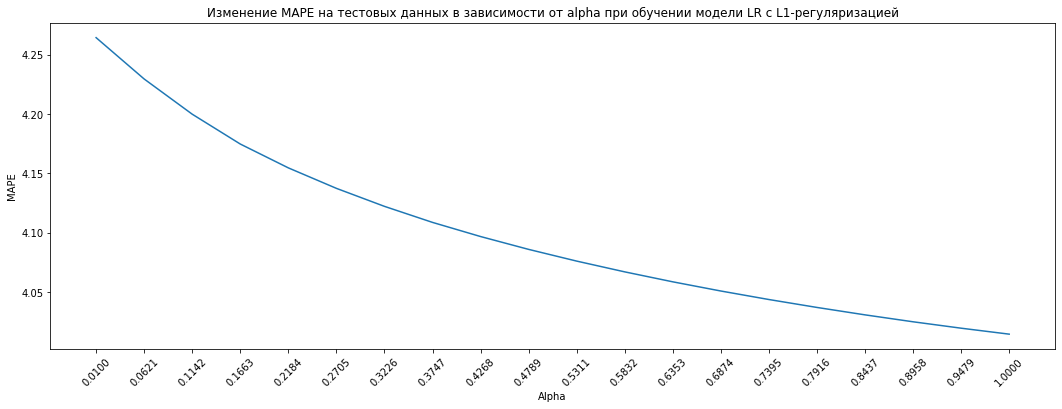

In [531]:
# Так как полиномиальная регрессия с выбранными через RFE признаками показала лучший результат, 
# то будем работать с ней и посмотрим на результат обучения модели при L1-регуляризации
# Для этот будем перебирать значения alpha, визуализируем динамику метрики при изменении значения и, наконец, обучим модель на лучшем показателе

alpha_list = np.linspace(0.01, 1, 20) # генерируем список значений alpha
test_scores = [] # создаём пустой список, куда будем помещать результаты обучения на тестовой выборке

for alpha in alpha_list: 
    lasso_poly = Ridge(alpha=alpha, max_iter=10000).fit(X_train_norm_poly, y_train) # обучаем модель линейной регрессии с L1-регуляризацией
    y_test_predict_poly = lasso_poly.predict(X_test_norm_poly) # делаем предсказание на тестовых данных
    test_scores.append(mean_absolute_percentage_error(y_test, y_test_predict_poly)) # считаем метрику MAPE на тестовых данных и вносим результат в список

# Визуализируем результаты для тестовых данных
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(alpha_list, test_scores)
ax.set_xlabel('Alpha')
ax.set_ylabel('MAPE')
ax.set_xticks(alpha_list)
ax.xaxis.set_tick_params(rotation=45)
ax.set_title('Изменение MAPE на тестовых данных в зависимости от alpha при обучении модели LR с L1-регуляризацией');

In [532]:
# Так как наилучший результат показало значение alpha равное 1, обучим соответствующую модель и посмотрим на метрику

lasso_model = Lasso(alpha=1).fit(X_train_norm_poly, y_train) # обучаем модель линейной регрессии с L1-регуляризацией и выбранным коэф. alpha
y_train_predict = lasso_model.predict(X_train_norm_poly) # делаем предсказание на тренировочных данных
y_test_predict = lasso_model.predict(X_test_norm_poly) # делаем предсказание на тестовых данных

# Смотрим на результат
print(f"MAPE на тренировочном наборе данных: {round(mean_absolute_percentage_error(y_train, y_train_predict), 3)} %")
print(f"MAPE на тестовом наборе данных: {round(mean_absolute_percentage_error(y_test, y_test_predict), 3)} %")

MAPE на тренировочном наборе данных: 6.249 %
MAPE на тестовом наборе данных: 4.271 %


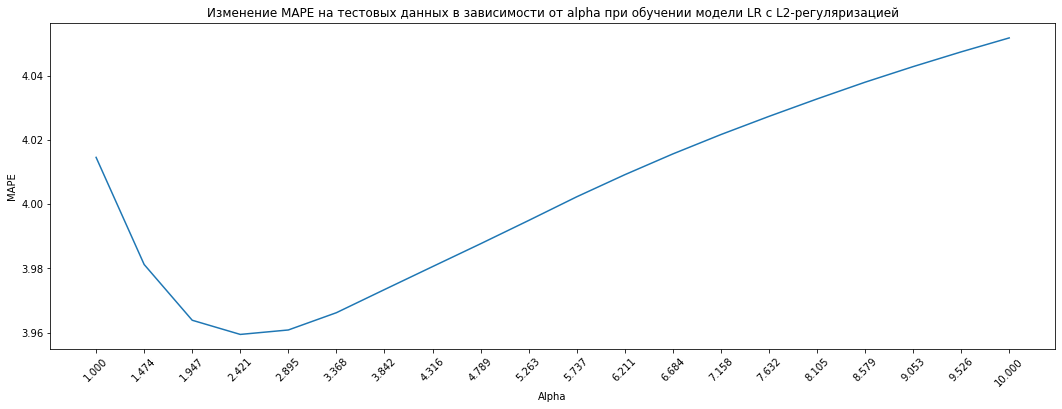

In [533]:
# Аналогично L1-регуляризации, посмотрим на результат обучения модели при разных значениях alpha в L2-регуляризации

alpha_list = np.linspace(1, 10, 20) # генерируем список значений alpha
test_scores = [] # создаём пустой список, куда будем помещать результаты обучения на тестовой выборке

for alpha in alpha_list: 
    ridge_poly = Ridge(alpha=alpha, max_iter=10000).fit(X_train_norm_poly, y_train) # обучаем модель линейной регрессии с L2-регуляризацией
    y_test_predict_poly = ridge_poly.predict(X_test_norm_poly) # делаем предсказание на тестовых данных
    test_scores.append(mean_absolute_percentage_error(y_test, y_test_predict_poly)) # считаем метрику MAPE на тестовых данных и вносим результат в список

# Визуализируем результаты для тестовых данных
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(alpha_list, test_scores)
ax.set_xlabel('Alpha')
ax.set_ylabel('MAPE')
ax.set_xticks(alpha_list)
ax.xaxis.set_tick_params(rotation=45)
ax.set_title('Изменение MAPE на тестовых данных в зависимости от alpha при обучении модели LR с L2-регуляризацией');

In [534]:
# Так как наилучший результат показало значение alpha равное 2.421, обучим соответствующую модель и посмотрим на метрику

ridge_poly = Ridge(alpha=2.421).fit(X_train_norm_poly, y_train) # обучаем модель линейной регрессии с L2-регуляризацией и выбранным коэф. alpha
y_train_predict = ridge_poly.predict(X_train_norm_poly) # делаем предсказание на тренировочных данных
y_test_predict = ridge_poly.predict(X_test_norm_poly) # делаем предсказание на тестовых данных

# Смотрим на результат
print(f"MAPE на тренировочном наборе данных: {round(mean_absolute_percentage_error(y_train, y_train_predict), 3)} %")
print(f"MAPE на тестовом наборе данных: {round(mean_absolute_percentage_error(y_test, y_test_predict), 3)} %")

MAPE на тренировочном наборе данных: 5.742 %
MAPE на тестовом наборе данных: 3.959 %




---


> **Итак, произведено обучение модели линейной регрессии несколькими разными способами.**

> Что получилось (метрика вида: 'MAPE на тренировочных данных / MAPE на тестовых данных'):

*   Обучение стандартной модели линейной регрессии (11.623 % / **7.465** %);
*   Обучение модели линейной регрессии на признаках, отобранных RFE (5.294 % / **4.272** %);
*   Обучение модели линейной регрессии на признаках, отобранных SelectKBest (9.66 % / **5.767** %)
*   Обучение модели линейной регрессии на признаках, отобранных RFE + нормализация (5.294 % / **4.272** %);
*   Обучение модели полиноминальной регрессии (7.691 % / **4.79** %);
*   Обучение модели полиноминальной регрессии на признаках, отобранных RFE + нормализация (6.249 % / **4.272** %);
*   Обучение модели полиноминальной регрессии на признаках, отобранных RFE + нормализация + L1-регуляризация (6.249 % / **4.271** %);
*   Обучение модели полиноминальной регрессии на признаках, отобранных RFE + нормализация + L2-регуляризация (5.742 % / **3.959** %);


> Сравнивать качество моделей необходимо по метрике на тестовой выборке, так как эти данные модель не видела.

> На основании полученных результатов можно сделать вывод, что лучшей показала себя модель полиноминальной регрессии, обученной на признаках, отобранных RFE, с проведённой нормализацией и L2-регуляризацией. Нам удалось улучшить результат почти **в 2 раза**, по сравнению с результатом обучения стандартной модели линейной регрессии.

# 5. Деплой

> Итак, переходим к завершающей стадии реализации проекта - развертыванию модели.

In [535]:
# Производим сериализацию модели и записываем результат в файл формата pkl

with open(r'population_model.pkl','wb') as model_pkl:
    pickle.dump(ridge_poly, model_pkl)

<p align="center">
  <img src="https://media.tenor.com/hB9OTbewrikAAAAj/work-work-in-progress.gif"/>
</p>